In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import pysindy as ps
import numpy.matlib
import mat73
import colorcet as cc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from numpy import asarray
from scipy import stats, signal, io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import BaggingRegressor
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Layer
from matplotlib.animation import FuncAnimation, FFMpegWriter
import keras.backend as K


%matplotlib notebook

2023-05-29 20:06:12.306941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 20:06:12.977110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-29 20:06:12.977156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-29 20:06:13.048780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-29 20:06:14.736613: W tensorflow/stream_executor/platform/de

In [53]:
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        
def scaler(data_in, scaler_in = None):

    if scaler_in is None:
        scaler_in = MinMaxScaler(feature_range=(-1, 1))
        #scaler_in.fit(data_in.flatten().reshape(-1,1))
        scaler_in.fit(data_in)
        
    #x = scaler_in.transform(data_in.flatten().reshape(-1,1)).reshape(data_in.shape)
    x = scaler_in.transform(data_in)
    x = StandardScaler(with_std=False).fit_transform(x)
    
    return x, scaler_in

C6 = cc.cm.CET_C6

def hankel_matrix(Xin, n_delay_coordinates, spacing=1):
    n_inputs, n_samples = Xin.shape

    X = np.zeros((n_inputs * (n_delay_coordinates), n_samples - spacing*(n_delay_coordinates-1)))
    for i in range(n_delay_coordinates):
        idxs = np.arange(spacing*i, spacing*(i+1) + n_samples - spacing*n_delay_coordinates)
        X[i*n_inputs:(i+1)*n_inputs] = Xin[:, idxs]
    return X

def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

def SVD_projection(data, rank=10):
    u, s, vh = np.linalg.svd(data, full_matrices=False)
    return vh[:rank,:]


In [3]:
def linear_regression(xtrain,ytrain):
    
    from sklearn.linear_model import LinearRegression

    L = LinearRegression()
    L.fit(xtrain,ytrain)
    ytrain_hat = L.predict(xtrain)
    r_squared = r2_score(ytrain, ytrain_hat, multioutput='variance_weighted')
    
    return r_squared, L

def SINDy_mapping(xtrain, ytrain, poly_order=3, alpha_in=.0001):

    lib = ps.PolynomialLibrary(degree=poly_order).fit(xtrain)
    Xi = lib.transform(xtrain)
    L = Lasso(alpha=alpha_in, max_iter=1000)
    L = BaggingRegressor(base_estimator=L, n_estimators=20, max_samples=.2, random_state=0)
    L.fit(Xi,ytrain)

    ytrain_hat = L.predict(Xi)
    r_squared = r2_score(ytrain, ytrain_hat, multioutput='variance_weighted')
    
    return r_squared, lib, L

def MLP_predict(xtrain, ytrain, activation_in='tanh', alpha_in=.001):

    alpha = alpha_in
    in_dim = xtrain.shape[1]
    out_dim = ytrain.shape[1]
    model = Sequential()
    model.add(Dense(in_dim, input_dim=in_dim, activation=activation_in, activity_regularizer=regularizers.L2(l2=alpha), kernel_initializer='he_uniform'))
    model.add(Dense(in_dim*2, activation=activation_in, activity_regularizer=regularizers.L2(l2=alpha), kernel_initializer='he_uniform'))
    model.add(Dense(out_dim, activation='linear', activity_regularizer=regularizers.L2(l2=alpha), kernel_initializer='he_uniform'))
    model.add(Dropout(.1))

    opt = keras.optimizers.Adam(learning_rate=.001)
    model.compile(loss='mse', optimizer=opt)
    model.fit(xtrain, ytrain, epochs=500, batch_size=1000, verbose=0, validation_data=(xtrain[:-1000,:],ytrain[:-1000,:]))
    
    r_squared = r2_score(ytrain, model.predict(xtrain), multioutput = 'variance_weighted')
    
    return r_squared, model

def knn_regress(xtrain, ytrain, n_neighbors=5, weights='distance'):
    
    from sklearn import neighbors
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    model = knn.fit(xtrain, ytrain)
        
    r_squared = r2_score(ytrain, model.predict(xtrain), multioutput = 'variance_weighted')
    
    return r_squared, model

In [4]:
def VAE(xtrain, ytrain, latent_dim=8, beta=.1, num_epochs=200):
    
    from keras import backend as K
    from keras import layers
        
    input_dim = xtrain.shape[1]
    output_dim = ytrain.shape[1]
    latent_dim = latent_dim
    input_data = keras.Input(shape=(input_dim,))
    
    class Sampling(Layer):
        """Uses (z_mean, z_log_var) to sample z"""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * .1*epsilon
    
    encoded = Dense(latent_dim, activation='linear')(input_data)
    z_mean = Dense(latent_dim, name="z_mean")(encoded)
    z_log_var = Dense(latent_dim, name="z_log_var")(encoded)
    z = Sampling()([z_mean, z_log_var])
    latent_inputs = keras.Input(shape=(latent_dim,))
    #decoded = Dense(output_dim, activation='tanh')(latent_inputs) 
    decoded = Dense(10, activation='tanh')(latent_inputs)
    decoded = Dense(output_dim, activation='linear')(decoded) 
    
    encoder = keras.Model(input_data, [z_mean, z_log_var, z], name="encoder")
    #encoder.load_weights("allen_pupil_encoder_weights.h5")
    #encoder.load_weights("test_encoder_weights.h5")

    #for layer in encoder.layers:
    #    layer.trainable = False
    decoder = keras.Model(latent_inputs, decoded, name="decoder")
    
    
    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            
            data1, data2 = data
            
            with tf.GradientTape() as tape:
                
                z_mean, z_log_var, z = self.encoder(data1)
                
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(keras.losses.mse(data2, reconstruction),0)

                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(kl_loss,0)
                
                total_loss = reconstruction_loss + beta*kl_loss
                
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
        
        def predict(self, data):
            z_mean,_,_ = self.encoder(data)
            decoded = self.decoder(z_mean)
            return decoded
            
    vae = VAE(encoder, decoder)
    opt = keras.optimizers.Adam(learning_rate=.02)
    vae.compile(optimizer=opt)
    vae.fit(xtrain, ytrain, epochs=num_epochs, batch_size=1000)
        
    r_squared = r2_score(ytrain, vae.predict(xtrain), multioutput = 'variance_weighted')

    return r_squared, vae, encoder, decoder

In [5]:
data_dir = '/home/ryraut/code/arousal'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [6]:
s = 1

data_dir = '/home/ryraut/code/arousal/outputs'

data_dict = mat73.loadmat(data_dir + '/' + str(s) + '_pupil.mat')
pupil = data_dict['pupil'].reshape(-1,1)
data_dict = mat73.loadmat(data_dir + '/' + str(s) + '_jrgeco.mat')
brain = data_dict['data'][:,mask_long]
data_dict = mat73.loadmat(data_dir + '/' + str(s) + '_face.mat')
face = data_dict['face'].reshape(-1,1)

pupil = pupil[800:,:]
brain = brain[800:,:]
face = face[800:,:]

Fs = 20
dt = 1/Fs
sos = signal.butter(2, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
pupil = signal.sosfiltfilt(sos, pupil, axis = 0)
face = signal.sosfiltfilt(sos, face, axis = 0)
brain = signal.sosfiltfilt(sos, brain, axis = 0)

In [ ]:
## DELAY EMBED
#Fs = 20
#dt = 1/Fs
#stackmax = 100
#spacing = 4
#r = 10
#nsamples = 6000
#alpha = .001

stackmax = 100
spacing = 4
r = 6
nsamples = 10000
Fs = 30
lag = 1 # in seconds
lag = lag*Fs*spacing

Hp = hankel_matrix(pupil.T,stackmax,spacing)
#Hpu, Hps, Hpvh = np.linalg.svd(Hp, full_matrices=False)

Y = np.concatenate((pupil,face,brain),axis=1)
Y = Y[spacing*(stackmax-1):,:]

#xtrain = (np.diag(Hps[:r])@Hpvh[:r,:nsamples]).transpose()
#xtrain = Hp[:,:nsamples].transpose()

polys = true_polys(stackmax, 1/Fs, r, center=False)
xtrain = (polys.T@Hp[:,:nsamples]).T
ytrain = Y[:nsamples,:]

xtrain, scale_x = scaler(xtrain)
ytrain, scale_y = scaler(ytrain)

xtrain = xtrain[lag:,:]
ytrain = ytrain[:-lag,:]
    
r_squared, model, encoder, decoder = VAE(xtrain, ytrain, latent_dim=4, beta=.1)

r_squared

<IPython.core.display.Javascript object>


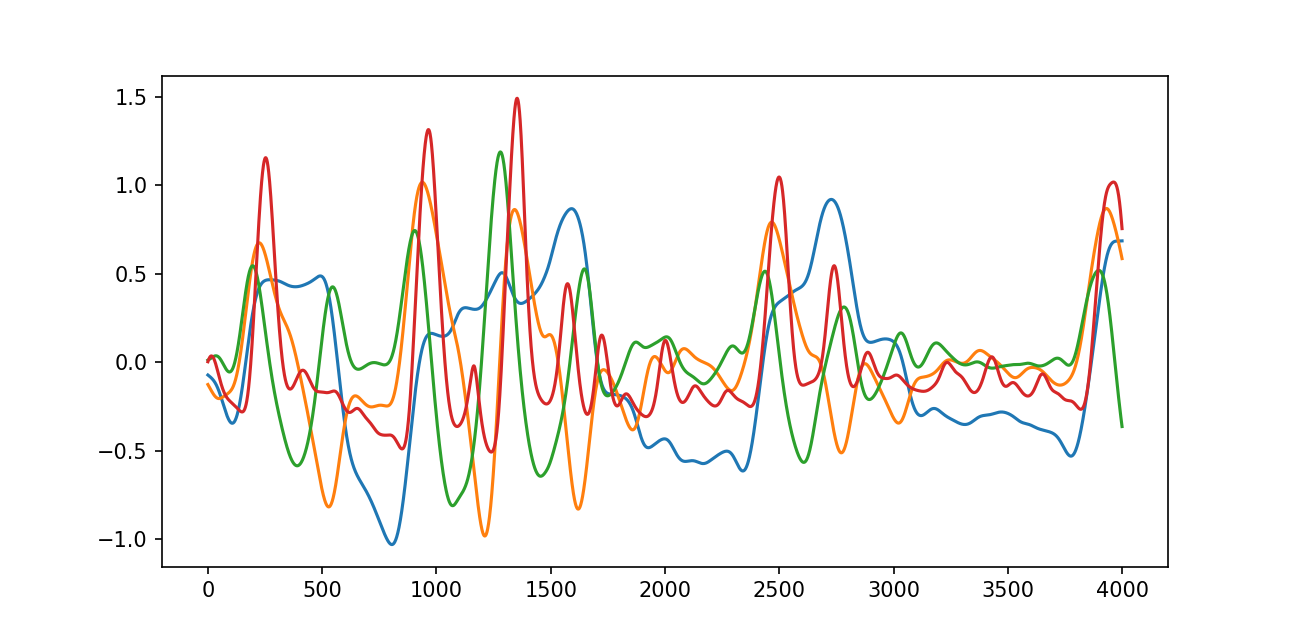

In [215]:
fig,ax = plt.subplots()
plt.plot(xtrain[:4000,:3])
plt.plot(ytrain[:4000,0])
#plt.plot(500000*test_y[:,5])
#plt.plot(model.predict(test_x).numpy()[:,[0,5]])
#plt.plot(xtrain[:,1])
plt.show()

<IPython.core.display.Javascript object>


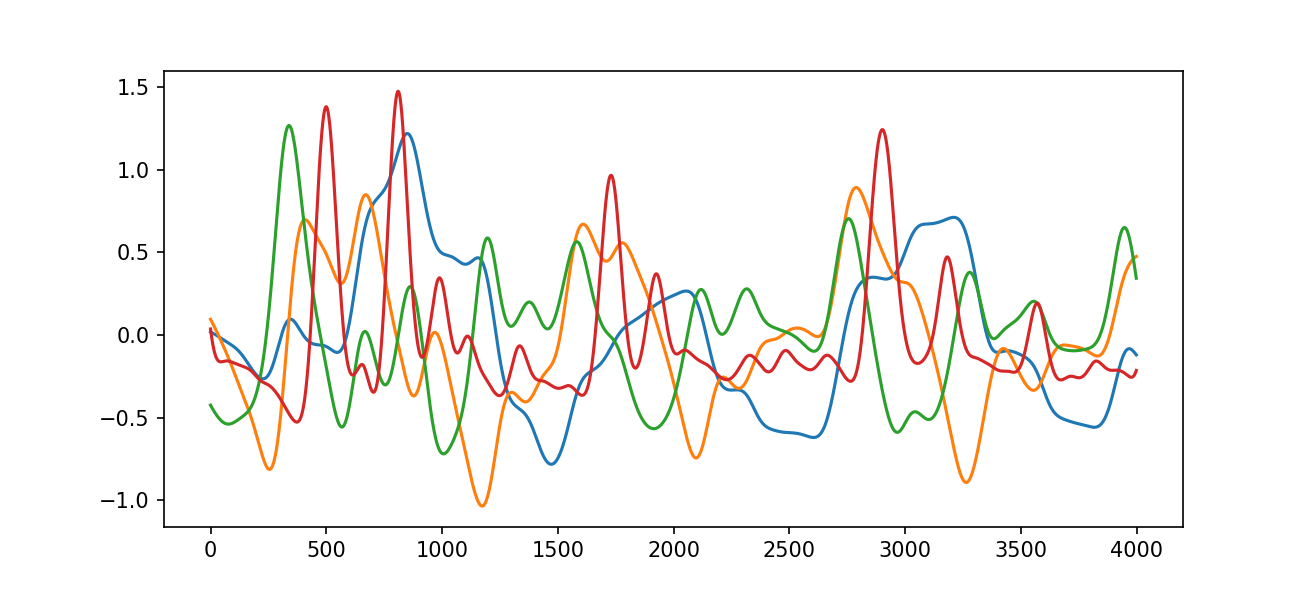

In [224]:
fig,ax = plt.subplots()
plt.plot(xtrain[:4000,:3])
plt.plot(ytrain[:4000,0])
#plt.plot(500000*test_y[:,5])
#plt.plot(model.predict(test_x).numpy()[:,[0,5]])
#plt.plot(xtrain[:,1])
plt.show()

<IPython.core.display.Javascript object>


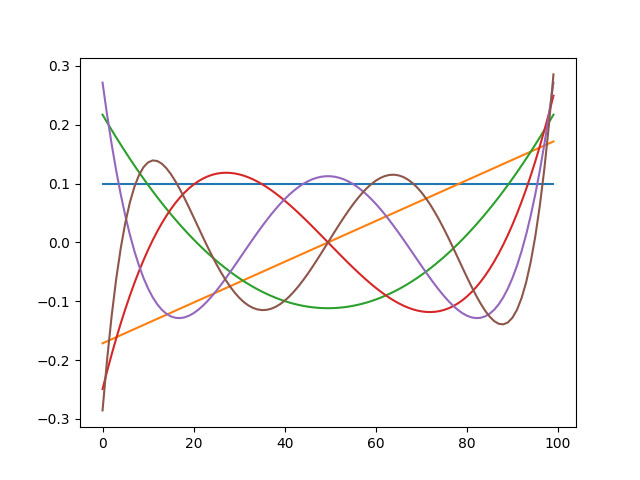

In [133]:
plt.plot(polys)

<IPython.core.display.Javascript object>


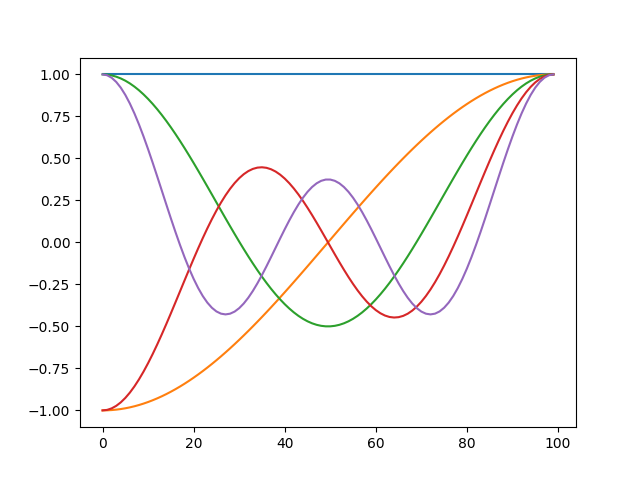

In [167]:
from scipy.special import legendre

def legendre_polys(n, domain):
    matrix = np.zeros((len(domain), n))
    for i in range(n):
        matrix[:, i] = legendre(i)(domain)
    return matrix

#domain = np.linspace(-1, 1, stackmax)
domain = np.cos(np.linspace(-np.pi,0,stackmax))
matrix = legendre_matrix(n, domain)

plt.plot(legendre_matrix(n,domain))

In [164]:
np.cos(np.pi)

-1.0

In [145]:
temp = legendre_polys(3)

In [146]:
temp

[poly1d([1.]),
 poly1d([1., 0.]),
 poly1d([ 1.5,  0. , -0.5]),
 poly1d([ 2.5,  0. , -1.5,  0. ])]

In [120]:
## GROUP

stackmax = 100
spacing = 6 #4
r = 6
nsamples = 8000
Fs = 30 #20
lag = 1 # in seconds
lag = lag*Fs*spacing

subjects = np.arange(1,10)
subjects = np.delete(subjects, [1, 2])

#subjects = subjects[:2]

decoders = []

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]

    # Load data
    data_dir = '/home/ryraut/code/arousal/outputs'
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_pupil.mat')
    pupil = data_dict['pupil'].reshape(-1,1)
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_face.mat')
    face = data_dict['face'].reshape(-1,1)
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_jrgeco.mat')
    brain = data_dict['data'][:,mask_long]
    pupil = pupil[800:,:]
    brain = brain[800:,:]
    face = face[800:,:]
    
    brain = signal.resample(brain,int(1.5*nsamples))
    pupil = signal.resample(pupil,int(1.5*nsamples))
    face = signal.resample(face,int(1.5*nsamples))

    
    #mean_data = np.mean(brain, axis=1)
    #mean_matrix = np.tile(mean_data, (brain.shape[1], 1)).T
    #brain = brain - mean_matrix
    #brain = np.diff(brain, axis=0)
    
    ## Preprocess
    sos = signal.butter(2, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
    pupil = signal.sosfiltfilt(sos, pupil, axis = 0)
    brain = signal.sosfiltfilt(sos, brain, axis = 0)
    face = signal.sosfiltfilt(sos, face, axis = 0)
    
    ## DELAY EMBED
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    #Hpu, Hps, Hpvh = np.linalg.svd(Hp, full_matrices=False)

    Y = np.concatenate((pupil,face,brain),axis=1)
    Y = Y[spacing*(stackmax-1):,:]

    
    polys = true_polys(stackmax, (1/Fs)*spacing, r, center=False)
    xtrain = (polys.T@Hp).T
    ytrain = Y

    xtrain, scale_x = scaler(xtrain)
    ytrain, scale_y = scaler(ytrain)

    xtrain = xtrain[lag:,:]
    ytrain = ytrain[:-lag,:]
    
    r_squared, model, encoder, decoder = VAE(xtrain, ytrain, latent_dim=6, beta=.1, num_epochs=100)
    
    decoders.append(model)
    
    print('Finished mouse ' + str(s+1) + '/' + str(len(subjects)))
    
    toc()

Epoch 1/100
12/12 [==============================] - 2s 87ms/step - loss: 0.1005 - reconstruction_loss: 0.0897 - kl_loss: 0.0232
Epoch 2/100
12/12 [==============================] - 1s 85ms/step - loss: 0.0721 - reconstruction_loss: 0.0660 - kl_loss: 0.0260
Epoch 3/100
12/12 [==============================] - 1s 83ms/step - loss: 0.0613 - reconstruction_loss: 0.0578 - kl_loss: 0.0356
Epoch 4/100
12/12 [==============================] - 1s 80ms/step - loss: 0.0593 - reconstruction_loss: 0.0540 - kl_loss: 0.0435
Epoch 5/100
12/12 [==============================] - 1s 83ms/step - loss: 0.0568 - reconstruction_loss: 0.0513 - kl_loss: 0.0482
Epoch 6/100
12/12 [==============================] - 1s 82ms/step - loss: 0.0553 - reconstruction_loss: 0.0505 - kl_loss: 0.0474
Epoch 7/100
12/12 [==============================] - 1s 79ms/step - loss: 0.0548 - reconstruction_loss: 0.0499 - kl_loss: 0.0479
Epoch 8/100
12/12 [==============================] - 1s 80ms/step - loss: 0.0536 - reconstruction

12/12 [==============================] - 1s 74ms/step - loss: 0.0477 - reconstruction_loss: 0.0421 - kl_loss: 0.0488
Epoch 65/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0469 - reconstruction_loss: 0.0420 - kl_loss: 0.0493
Epoch 66/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0473 - reconstruction_loss: 0.0424 - kl_loss: 0.0495
Epoch 67/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0473 - reconstruction_loss: 0.0425 - kl_loss: 0.0497
Epoch 68/100
12/12 [==============================] - 1s 93ms/step - loss: 0.0482 - reconstruction_loss: 0.0431 - kl_loss: 0.0497
Epoch 69/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0476 - reconstruction_loss: 0.0425 - kl_loss: 0.0503
Epoch 70/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0485 - reconstruction_loss: 0.0437 - kl_loss: 0.0498
Epoch 71/100
12/12 [==============================] - 1s 78ms/step - loss: 0.0487 - reconstruction_loss

12/12 [==============================] - 1s 73ms/step - loss: 0.0481 - reconstruction_loss: 0.0437 - kl_loss: 0.0435
Epoch 27/100
12/12 [==============================] - 1s 79ms/step - loss: 0.0477 - reconstruction_loss: 0.0436 - kl_loss: 0.0444
Epoch 28/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0478 - reconstruction_loss: 0.0433 - kl_loss: 0.0447
Epoch 29/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0475 - reconstruction_loss: 0.0431 - kl_loss: 0.0454
Epoch 30/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0478 - reconstruction_loss: 0.0433 - kl_loss: 0.0442
Epoch 31/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0479 - reconstruction_loss: 0.0434 - kl_loss: 0.0452
Epoch 32/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0478 - reconstruction_loss: 0.0430 - kl_loss: 0.0438
Epoch 33/100
12/12 [==============================] - 1s 78ms/step - loss: 0.0476 - reconstruction_loss

12/12 [==============================] - 1s 75ms/step - loss: 0.0451 - reconstruction_loss: 0.0403 - kl_loss: 0.0507
Epoch 90/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0456 - reconstruction_loss: 0.0403 - kl_loss: 0.0519
Epoch 91/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0460 - reconstruction_loss: 0.0408 - kl_loss: 0.0525
Epoch 92/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0452 - reconstruction_loss: 0.0400 - kl_loss: 0.0518
Epoch 93/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0455 - reconstruction_loss: 0.0404 - kl_loss: 0.0517
Epoch 94/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0460 - reconstruction_loss: 0.0401 - kl_loss: 0.0528
Epoch 95/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0451 - reconstruction_loss: 0.0402 - kl_loss: 0.0515
Epoch 96/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0454 - reconstruction_loss

12/12 [==============================] - 1s 73ms/step - loss: 0.0304 - reconstruction_loss: 0.0266 - kl_loss: 0.0366
Epoch 52/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0302 - reconstruction_loss: 0.0266 - kl_loss: 0.0358
Epoch 53/100
12/12 [==============================] - 1s 79ms/step - loss: 0.0304 - reconstruction_loss: 0.0265 - kl_loss: 0.0365
Epoch 54/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0303 - reconstruction_loss: 0.0267 - kl_loss: 0.0364
Epoch 55/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0302 - reconstruction_loss: 0.0265 - kl_loss: 0.0357
Epoch 56/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0296 - reconstruction_loss: 0.0262 - kl_loss: 0.0358
Epoch 57/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0301 - reconstruction_loss: 0.0264 - kl_loss: 0.0364
Epoch 58/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0300 - reconstruction_loss

12/12 [==============================] - 1s 73ms/step - loss: 0.0466 - reconstruction_loss: 0.0421 - kl_loss: 0.0441
Epoch 14/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0462 - reconstruction_loss: 0.0419 - kl_loss: 0.0451
Epoch 15/100
12/12 [==============================] - 1s 78ms/step - loss: 0.0466 - reconstruction_loss: 0.0420 - kl_loss: 0.0428
Epoch 16/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0462 - reconstruction_loss: 0.0416 - kl_loss: 0.0444
Epoch 17/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0461 - reconstruction_loss: 0.0425 - kl_loss: 0.0423
Epoch 18/100
12/12 [==============================] - 1s 72ms/step - loss: 0.0461 - reconstruction_loss: 0.0419 - kl_loss: 0.0430
Epoch 19/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0464 - reconstruction_loss: 0.0418 - kl_loss: 0.0433
Epoch 20/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0456 - reconstruction_loss

12/12 [==============================] - 1s 74ms/step - loss: 0.0423 - reconstruction_loss: 0.0379 - kl_loss: 0.0437
Epoch 77/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0423 - reconstruction_loss: 0.0381 - kl_loss: 0.0432
Epoch 78/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0427 - reconstruction_loss: 0.0380 - kl_loss: 0.0444
Epoch 79/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0425 - reconstruction_loss: 0.0380 - kl_loss: 0.0433
Epoch 80/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0423 - reconstruction_loss: 0.0381 - kl_loss: 0.0423
Epoch 81/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0424 - reconstruction_loss: 0.0381 - kl_loss: 0.0449
Epoch 82/100
12/12 [==============================] - 1s 78ms/step - loss: 0.0425 - reconstruction_loss: 0.0379 - kl_loss: 0.0442
Epoch 83/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0421 - reconstruction_loss

12/12 [==============================] - 1s 75ms/step - loss: 0.0412 - reconstruction_loss: 0.0369 - kl_loss: 0.0405
Epoch 39/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0409 - reconstruction_loss: 0.0367 - kl_loss: 0.0413
Epoch 40/100
12/12 [==============================] - 1s 81ms/step - loss: 0.0409 - reconstruction_loss: 0.0369 - kl_loss: 0.0409
Epoch 41/100
12/12 [==============================] - 1s 80ms/step - loss: 0.0408 - reconstruction_loss: 0.0368 - kl_loss: 0.0415
Epoch 42/100
12/12 [==============================] - 1s 79ms/step - loss: 0.0411 - reconstruction_loss: 0.0365 - kl_loss: 0.0415
Epoch 43/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0409 - reconstruction_loss: 0.0365 - kl_loss: 0.0412
Epoch 44/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0410 - reconstruction_loss: 0.0365 - kl_loss: 0.0412
Epoch 45/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0399 - reconstruction_loss

Epoch 1/100
12/12 [==============================] - 2s 74ms/step - loss: 0.1442 - reconstruction_loss: 0.1084 - kl_loss: 0.0854
Epoch 2/100
12/12 [==============================] - 2s 143ms/step - loss: 0.0771 - reconstruction_loss: 0.0697 - kl_loss: 0.0539
Epoch 3/100
12/12 [==============================] - 3s 230ms/step - loss: 0.0688 - reconstruction_loss: 0.0621 - kl_loss: 0.0513
Epoch 4/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0652 - reconstruction_loss: 0.0593 - kl_loss: 0.0484
Epoch 5/100
12/12 [==============================] - 1s 79ms/step - loss: 0.0623 - reconstruction_loss: 0.0583 - kl_loss: 0.0467
Epoch 6/100
12/12 [==============================] - 1s 81ms/step - loss: 0.0614 - reconstruction_loss: 0.0567 - kl_loss: 0.0469
Epoch 7/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0594 - reconstruction_loss: 0.0545 - kl_loss: 0.0462
Epoch 8/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0587 - reconstructi

12/12 [==============================] - 1s 78ms/step - loss: 0.0501 - reconstruction_loss: 0.0441 - kl_loss: 0.0577
Epoch 65/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0499 - reconstruction_loss: 0.0446 - kl_loss: 0.0575
Epoch 66/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0500 - reconstruction_loss: 0.0443 - kl_loss: 0.0583
Epoch 67/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0499 - reconstruction_loss: 0.0443 - kl_loss: 0.0573
Epoch 68/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0497 - reconstruction_loss: 0.0445 - kl_loss: 0.0562
Epoch 69/100
12/12 [==============================] - 1s 78ms/step - loss: 0.0505 - reconstruction_loss: 0.0442 - kl_loss: 0.0584
Epoch 70/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0501 - reconstruction_loss: 0.0445 - kl_loss: 0.0580
Epoch 71/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0494 - reconstruction_loss

12/12 [==============================] - 1s 73ms/step - loss: 0.0443 - reconstruction_loss: 0.0398 - kl_loss: 0.0401
Epoch 27/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0445 - reconstruction_loss: 0.0405 - kl_loss: 0.0387
Epoch 28/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0440 - reconstruction_loss: 0.0403 - kl_loss: 0.0389
Epoch 29/100
12/12 [==============================] - 1s 75ms/step - loss: 0.0442 - reconstruction_loss: 0.0402 - kl_loss: 0.0390
Epoch 30/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0443 - reconstruction_loss: 0.0403 - kl_loss: 0.0394
Epoch 31/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0436 - reconstruction_loss: 0.0397 - kl_loss: 0.0400
Epoch 32/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0431 - reconstruction_loss: 0.0402 - kl_loss: 0.0387
Epoch 33/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0435 - reconstruction_loss

12/12 [==============================] - 1s 75ms/step - loss: 0.0411 - reconstruction_loss: 0.0368 - kl_loss: 0.0423
Epoch 90/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0412 - reconstruction_loss: 0.0367 - kl_loss: 0.0433
Epoch 91/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0411 - reconstruction_loss: 0.0365 - kl_loss: 0.0432
Epoch 92/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0416 - reconstruction_loss: 0.0371 - kl_loss: 0.0426
Epoch 93/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0407 - reconstruction_loss: 0.0367 - kl_loss: 0.0426
Epoch 94/100
12/12 [==============================] - 1s 72ms/step - loss: 0.0418 - reconstruction_loss: 0.0370 - kl_loss: 0.0426
Epoch 95/100
12/12 [==============================] - 1s 77ms/step - loss: 0.0419 - reconstruction_loss: 0.0370 - kl_loss: 0.0448
Epoch 96/100
12/12 [==============================] - 1s 74ms/step - loss: 0.0407 - reconstruction_loss

In [165]:
def plot_latent_space(decoder, n=5, figsize=8):
    
    # display n*n 2D manifold
    digit_size = 128
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample,verbose=False)
            #x_decoded = scale_y.inverse_transform(x_decoded)
            
            outmat = np.zeros((16384,1), dtype=np.single)
            outmat[mask_long] = x_decoded[:,2:].T
            outmat = np.ma.masked_where(outmat==0, outmat)

            digit = outmat.reshape(digit_size, digit_size, order='F')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    np.ma.masked_where(figure==0, figure)
    figure[figure==0] = np.nan
    
    plt.style.use('dark_background')
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks([])#pixel_range, sample_range_x)
    plt.yticks([])#pixel_range, sample_range_y)

    plt.xlabel("Latent dim. 1",fontsize=16, **{'fontname':'Arial'})
    plt.ylabel("Latent dim. 2",fontsize=16, **{'fontname':'Arial'})
    #plt.axis('off')
    cmap = cm.get_cmap('magma').copy()
    #cmap = cc.cm.CET_L3
    #cmap = cm.get_cmap('viridis').copy()
    cmap.set_bad(color='black')
    plt.imshow(figure, cmap=cmap)
    plt.show()
    
    plt.style.use('default')

    return figure


In [ ]:
fig = plot_latent_space(mean_decoder, n=5, figsize=7)

In [230]:
## ENSEMBLE PREDICTIONS
num_bins = 100

lim = 1
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))


Z = np.zeros((num_bins,num_bins,ytrain.shape[1]))
tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))
    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((0*xx[:,i],xx[:,i],yy[:,i])).T, verbose=False)
    j+=1
toc()


In [215]:
def plot_allen_ccf(ax):
    #allen_ccf1 = [np.where(arr > 128, arr, np.nan) for arr in allen_ccf]
    for i in range(len(allen_ccf)):
        ax.plot(allen_ccf[i][:,0],allen_ccf[i][:,1],'w', lw=.25)

<IPython.core.display.Javascript object>


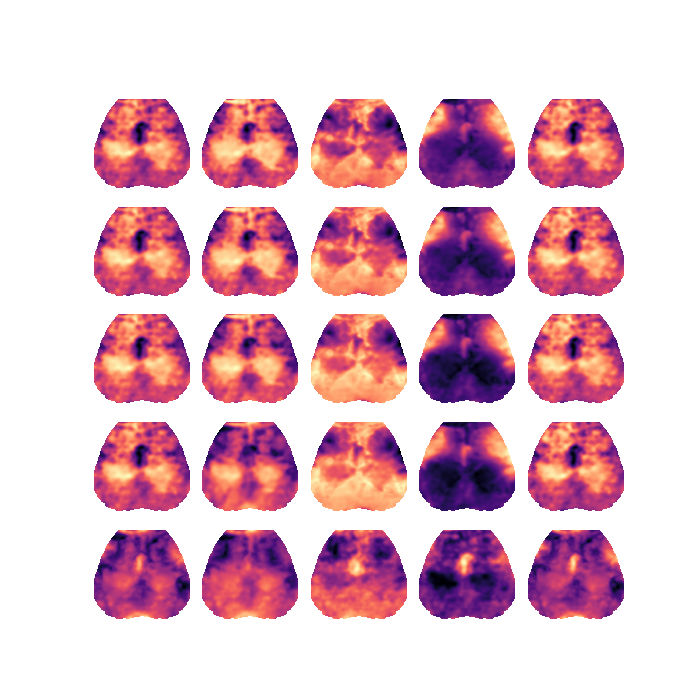

In [83]:
outmat = np.zeros((16384,1), dtype=np.single)
outmat = np.ma.masked_where(~mask_long.reshape(-1,1), outmat)

fig, axes = plt.subplots(5,5,sharex='col',figsize=(7,7))

cmap = cm.get_cmap('magma').copy()
cmap.set_bad(color='white')

axes = axes.flatten()

c = 5

#Z_norm = stats.zscore(Z,axis=1)
for i, ax in enumerate(axes):
    
    ii,j = np.divmod(i,5)
    
    outmat[mask_long] = Z[99-ii*24,j*24,2:].reshape(-1,1)
    #outmat[~mask_long] = -10
    digit = outmat.reshape(128, 128, order='F')

    #plot_allen_ccf(ax)
    #ax.imshow(digit, vmin=-c, vmax=c, cmap=cmap)
    ax.imshow(digit, cmap=cmap)

    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<IPython.core.display.Javascript object>


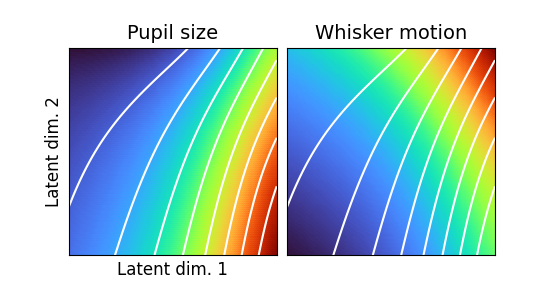

/tmp/ipykernel_29462/1339411410.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax[v].pcolormesh(xx, yy, z, edgecolors='face', cmap='turbo', vmin=np.min(z), vmax=np.max(z))


In [232]:
plt.style.use('default')

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2,figsize=(5.5, 3))
ax = ax.ravel()
fig.subplots_adjust(wspace=0.05)

titles=['Pupil size','Whisker motion']

for v in range(2):
    ax[v].grid(False)
    ax[v].axis('square')
    z = Z[:,:,v]
    p = ax[v].pcolormesh(xx, yy, z, edgecolors='face', cmap='turbo', vmin=np.min(z), vmax=np.max(z))

    levels = np.linspace(np.min(Z[:,:,0]), np.max(Z[:,:,0]), 10)
    ax[v].contour(xx, yy, Z[:,:,0], levels, colors='w', linestyles='solid')

    ax[v].set_xlim([-lim,lim])
    ax[v].set_ylim([-lim,lim])

    ax[v].set_xticks([])
    ax[v].set_yticks([])
    
    ax[v].set_title(titles[v], size=14, **{'fontname':'Arial'})

ax[0].set_xlabel('Latent dim. 1', size=12, **{'fontname':'Arial'})
ax[0].set_ylabel('Latent dim. 2', size=12, **{'fontname':'Arial'})

plt.show()

## Koopman eigenfunctions

In [8]:
def make_r_theta_vals(num_bins, lim=1):
    thetas_radians = np.linspace(-np.pi,np.pi,num_bins)
    radii = np.linspace(0,lim*1.5,num_bins)
    return thetas_radians, radii

In [124]:
num_bins = 100
lim = 1

xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))

thetas_radians, radii = make_r_theta_vals(num_bins,lim)
tr,rr = np.meshgrid(thetas_radians,radii)
x_vals = rr * np.cos(tr)
y_vals = rr * np.sin(tr)

Z = np.zeros((num_bins,num_bins,ytrain.shape[1]))
tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))

    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((0*x_vals[:,i],x_vals[:,i],y_vals[:,i],0*x_vals[:,i],0*x_vals[:,i],0*x_vals[:,i])).T)
        #Z[:,i,:] = Z[:,i,:] + scale_y.inverse_transform(d.predict(.5*np.vstack((yy[:,i],.25*np.cos(tr)[:,i],.25*np.sin(tr)[:,i])).T))[:,:7]
    j+=1
toc()


Decoder 1/7
Decoder 2/7
Decoder 3/7
Decoder 4/7
Decoder 5/7
Decoder 6/7
Decoder 7/7
Elapsed time is 13.41420316696167 seconds.


<IPython.core.display.Javascript object>


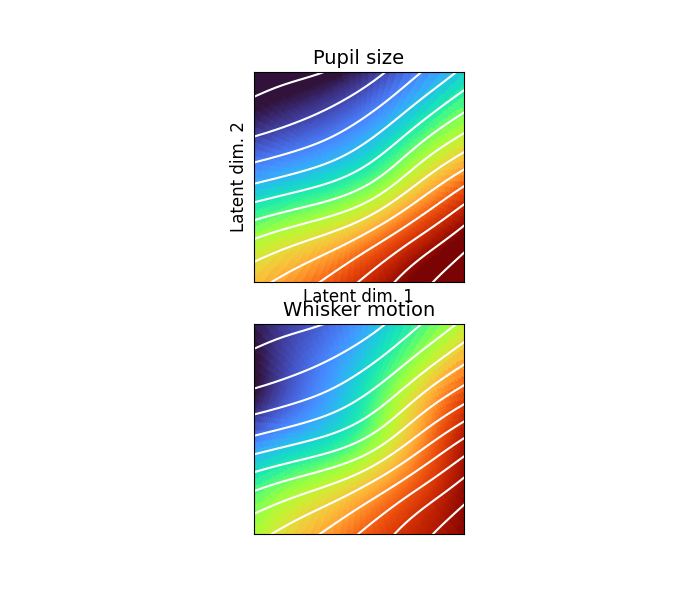

/tmp/ipykernel_767/3662044382.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax[v].pcolormesh(x_vals, y_vals, z, edgecolors='face', cmap='turbo', vmin=np.min(z)*.8, vmax=np.max(z)*.8)


In [125]:
plt.style.use('default')

from mpl_toolkits.axes_grid1 import make_axes_locatable

#fig, ax = plt.subplots(1,2,figsize=(5.5, 3))
fig, ax = plt.subplots(2,1,figsize=(7, 6))
ax = ax.ravel()
fig.subplots_adjust(wspace=0.05)

titles=['Pupil size','Whisker motion']

for v in range(2):
    ax[v].grid(False)
    ax[v].axis('square')
    z = Z[:,:,v]
    p = ax[v].pcolormesh(x_vals, y_vals, z, edgecolors='face', cmap='turbo', vmin=np.min(z)*.8, vmax=np.max(z)*.8)

    levels = np.linspace(np.min(Z[:,:,0]), np.max(Z[:,:,0]), 15)
    ax[v].contour(x_vals, y_vals, Z[:,:,0], levels, colors='w', linestyles='solid')

    ax[v].set_xlim([-lim,lim])
    ax[v].set_ylim([-lim,lim])

    ax[v].set_xticks([])
    ax[v].set_yticks([])
    
    ax[v].set_title(titles[v], size=14, **{'fontname':'Arial'})

ax[0].set_xlabel('Latent dim. 1', size=12, **{'fontname':'Arial'})
ax[0].set_ylabel('Latent dim. 2', size=12, **{'fontname':'Arial'})

plt.show()

<IPython.core.display.Javascript object>


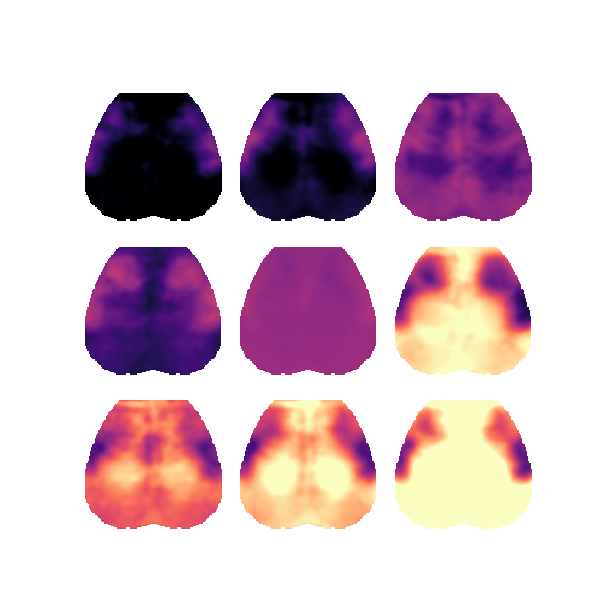

In [132]:
plt.style.use('default')
#plt.style.use('dark_background')

# Create the figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(6,6))

# Define the specific theta and radius values for each subplot
theta_values = (np.pi/4)*np.array([3, 2, 1, 4, 2, 0, 5, 6, 7])  # angle
center = (1, 1)  # Center of the grid
radius_values = [np.sqrt((x - center[0])**2 + (y - center[1])**2) for x in range(3) for y in range(3)]

# Iterate over the subplots and plot the polar images
for i in range(3):
    for j in range(3):
        
        # Get the theta and radius values for this subplot
        theta = theta_values[i*3 + j]
        radius = 1*radius_values[i*3 + j]        
        
        # Calculate the polar image for this subplot
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        temp = np.zeros((10400,1))
        for d in decoders:
            temp = temp + d.predict(np.vstack((0,x,y,0,0,0)).T).numpy()[:,2:].T
        outmat[mask_long] = temp.copy()
        image = outmat.reshape(128, 128, order='F')
                
        # Plot the image on the subplot
        ax = axes[i, j]
        ax.imshow(image, cmap='magma', vmin=-2.5, vmax=2.5)
        #ax.set_title(f'Subplot {i+1}-{j+1}')
        #ax.set_title(f'{np.round(radius,2)},{np.round(theta,2)}')
        ax.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


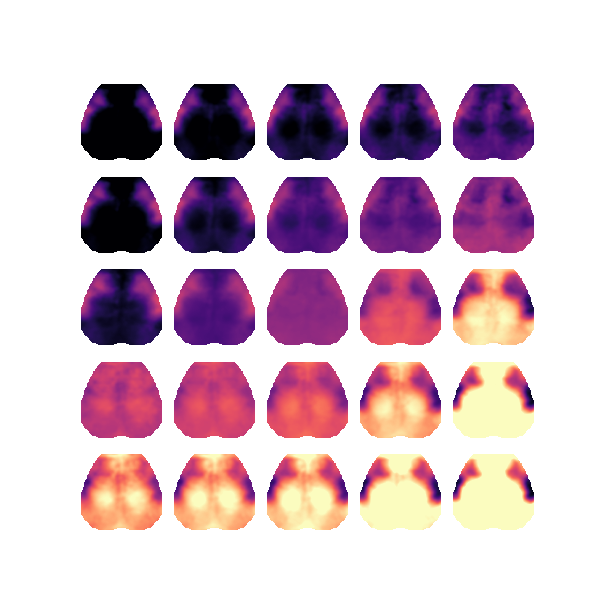

In [41]:
plt.style.use('default')
#plt.style.use('dark_background')

# Create the figure and subplots
fig, axes = plt.subplots(5, 5, figsize=(6,6))

# Define the specific theta and radius values for each subplot
theta_values = (np.pi/6)*np.array([4,3.5,3,2.5,2,
                                   4.5,4,3,2,1.5,
                                   6,6,0,0, 0,
                                   7.5,8,9, 10, 10.5, 
                                   8,8.5,9, 9.5, 10])  # angle
center = (2, 2)  # Center of the grid
radius_values = [np.sqrt((x - center[0])**2 + (y - center[1])**2) for x in range(5) for y in range(5)]

outmat = np.zeros((16384,1), dtype=np.single)
outmat = np.ma.masked_where(~mask_long.reshape(-1,1), outmat)

# Iterate over the subplots and plot the polar images
for i in range(5):
    for j in range(5):
        # Get the theta and radius values for this subplot
        theta = theta_values[i*5 + j]
        radius = .25*radius_values[i*5 + j]        
        
        # Calculate the polar image for this subplot
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        temp = np.zeros((10400,1))
        for d in decoders:
            temp = temp + d.predict(np.vstack((0,x,y,0,0,0)).T).numpy()[:,2:].T
        outmat[mask_long] = temp.copy()
        image = outmat.reshape(128, 128, order='F')
        
        #print(x,y)
        
        # Plot the image on the subplot
        ax = axes[i, j]
        ax.imshow(image, cmap='magma', vmin=-1.5, vmax=1.5)
        #ax.set_title(f'Subplot {i+1}-{j+1}')
        #ax.set_title(f'{np.round(radius,2)},{np.round(theta,2)}')
        ax.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Show the plot
plt.show()


## CLUSTERING

<IPython.core.display.Javascript object>


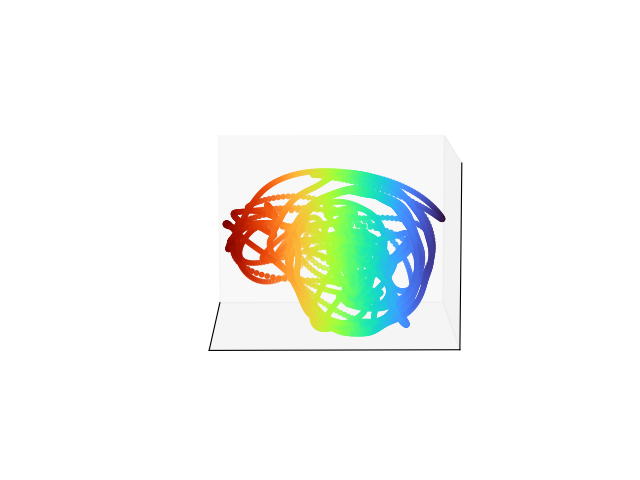

In [281]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = phi.shape[0]
colors = phi[:,1]
ax.scatter(phi[:lim,0],phi[:lim,1],phi[:lim,2],s=40,marker ='.',c=colors[:lim],cmap='turbo')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.view_init(31,39) #0,1,3 view

plt.show()

<IPython.core.display.Javascript object>


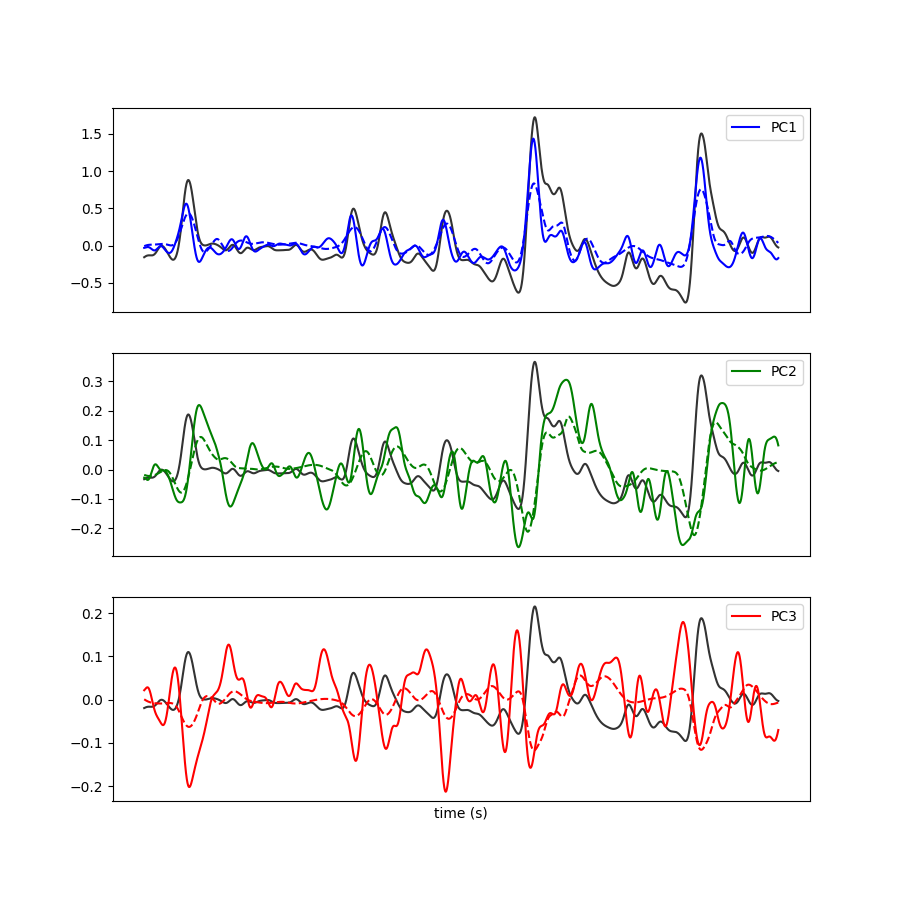

In [160]:
## PC DYNAMICS

fig, axes = plt.subplots(3,1,sharex='col',figsize=(9,9))

dt = .05
t = np.arange(0,ytest.shape[0]*dt,dt)
plt.xlabel("time (s)")

pupil_plot = pupil[-ytest.shape[0]-lag:-lag]
pupil_plot = (1/np.max(pupil_plot))*pupil_plot

face_plot = face[-ytest.shape[0]-lag:-lag]
face_plot = (1/np.max(face_plot))*face_plot

labels = ["PC1", "PC2", "PC3", "PC4"]

ax = 0
#axes[ax].plot(t,1.2*np.max(ytest[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(ytest[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,ytest[:,ax],'b',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'b',linestyle='dashed',alpha=1)
axes[ax].legend(loc="upper right")
axes[ax].set_xticks([])
    
ax = 1
#axes[ax].plot(t,1.2*np.max(ytest[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(ytest[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,ytest[:,ax],'g',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'g',linestyle='dashed')
axes[ax].legend(loc="upper right")
axes[ax].set_xticks([])

ax = 2
#axes[ax].plot(t,1.2*np.max(ytest[:,ax])*face_plot,'y',alpha=.6)
axes[ax].plot(t,1.2*np.max(ytest[:,ax])*pupil_plot,'k',alpha=.8)
axes[ax].plot(t,ytest[:,ax],'r',label=labels[ax])
axes[ax].plot(t,ytest_hat[:,ax],'r',linestyle='dashed')
axes[ax].legend(loc="upper right")
axes[ax].set_xticks([])

#ax = 3
#axes[ax].plot(t,1.2*np.max(ytest[:,ax])*face_plot,'y',alpha=.6)
#axes[ax].plot(t,1.2*np.max(ytest[:,ax])*pupil_plot,'k',alpha=.8)
#axes[ax].plot(t,ytest[:,3],'m',label=labels[ax])
#axes[ax].plot(t,ytest_hat[:,ax],'m',linestyle='dashed')
#axes[ax].legend(loc="upper right")
#axes[ax].set_xticks([])

#plt.suptitle('Widefield reconstructions from pupil size')
plt.show()

#colors = ["r","g","b"]
#for i,ax in enumerate(axes):
#  axs[i].plot([0,1],[1,0],color=colors[i]

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(StandardScaler().fit_transform(yproj))
colors = kmeans.labels_[nsamples2:-lag]
#colors = face[spacing*(stackmax-1)+nsamples2+lag:]

<IPython.core.display.Javascript object>


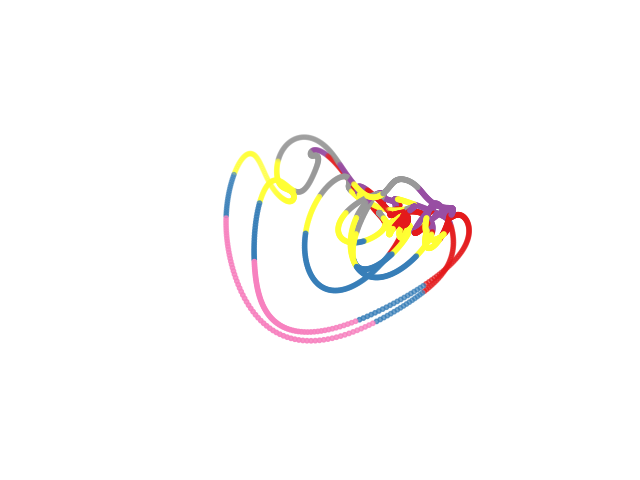

117/117 [==============================] - 0s 1ms/step


In [134]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = ytest.shape[0]
#utest = ytest_hat#(np.diag(Hps[:r])@Hpvh[:r,lag+nsamples2:]).transpose()
utest,_,_ = encoder.predict(xtest)
ax.scatter(utest[:lim,0],utest[:lim,1],utest[:lim,2],s=40,marker ='.',c=colors[:lim],cmap='Set1')
#ax.scatter(utest[:lim,0],utest[:lim,1],utest[:lim,2],s=40,marker='.',c=colors[:lim],cmap='plasma')
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#plt.axis('off')

#ax.view_init(39,31) #0,1,2 view
ax.view_init(31,39) #0,1,3 view

plt.show()

# DYNAMICS

In [817]:
## DYNAMICS

dt = .05
r_d = 3
#t = np.arange(0, y.shape[0], dt)
#tspan = (t[0],t_train[-1])

# LASSO
lasso_optimizer = Lasso(alpha=.00002, max_iter=1000, fit_intercept=False)
athresh = .98
bthresh = 2.83757971
cthresh = 6.9
thresholds = np.tile(np.array([athresh, bthresh, cthresh]),(56,1))
thresholds[0,:] = 10

# Instantiate and fit the SINDy model
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=.033),
    #optimizer=ps.SR3(thresholds=thresholds, thresholder = 'weighted_l0'),
    #optimizer=lasso_optimizer,
    differentiation_method=ps.SmoothedFiniteDifference(drop_endpoints=True),
    feature_library=ps.PolynomialLibrary(degree=5),
    #feature_names=["v1", "v2", "v3"]
)
#temp,_ = scaler2((np.diag(Hps[:r_d])*(1/np.sum(Hps))@Hpvh[:r_d,:]).T)
#temp,_ = scaler2(Hpvh[:r_d,:].T)
temp = Hpvh[:r_d,:].T
model.fit(temp, t=dt, ensemble=True, library_ensemble=False)
#temp,_,_ = encoder.predict(xtrain)
#model.fit(temp, t=dt)
model.print()

(x0)' = -0.136 x1
(x1)' = 0.149 x0 + -0.147 x2
(x2)' = 0.013 x1 + -0.084 x2 + -10.506 x0 x1


In [818]:
dt = .05
t = np.arange(0, dt*len(2*temp), dt)
x0 = temp[1000,:r_d]
x_sim = model.simulate(x0, t)

<IPython.core.display.Javascript object>


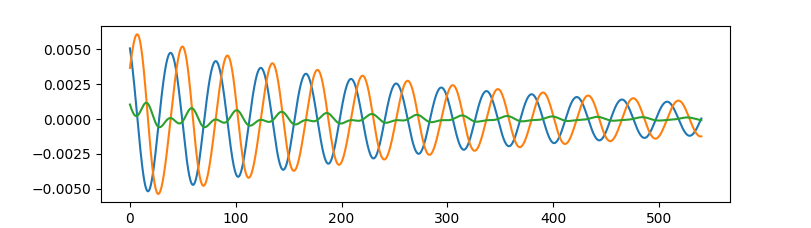

In [819]:
fig, ax = plt.subplots()
#plt.plot(t,temp[:,:2])
plt.plot(t,x_sim[:,:])
plt.xlabel("time (s)")
plt.show()

<IPython.core.display.Javascript object>


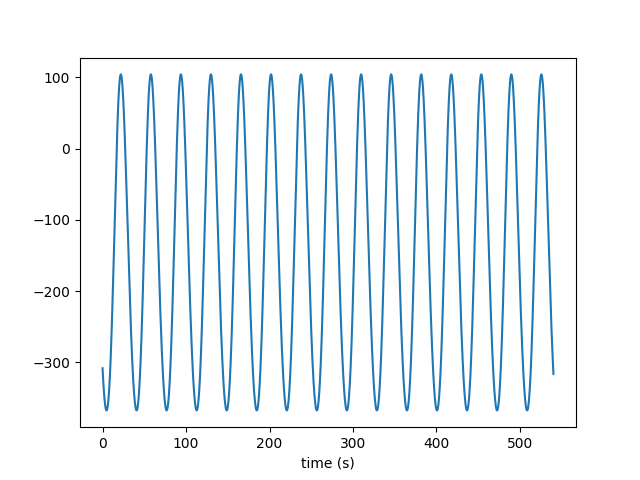

In [816]:
#pupil_sim = x_sim@(Hpu[0,:r_d].T)
pupil_sim = x_sim@np.diag(Hps[:r_d])@(Hpu[0,:r_d].T)


fig,ax = plt.subplots()
#plt.plot(t,.0001*pupil[lag+spacing*(stackmax-1):nsamples+spacing*(stackmax-1)])
plt.plot(t,pupil_sim)
plt.xlabel("time (s)")
plt.show()

In [778]:
#temp,_,_ = encoder.predict(x_sim)
temp = decoder.predict(x_sim)

fig,ax = plt.subplots()
plt.plot(t,ytrain[:,0])
plt.plot(t,temp[:,0])
plt.xlabel("time (s)")
plt.show()

NameError: name 'decoder' is not defined

In [821]:
np.save('xtrain_pupil', temp)
#temp,_,_ = encoder.predict(xtest)
#np.save('xtrain_pupil', temp)

<IPython.core.display.Javascript object>


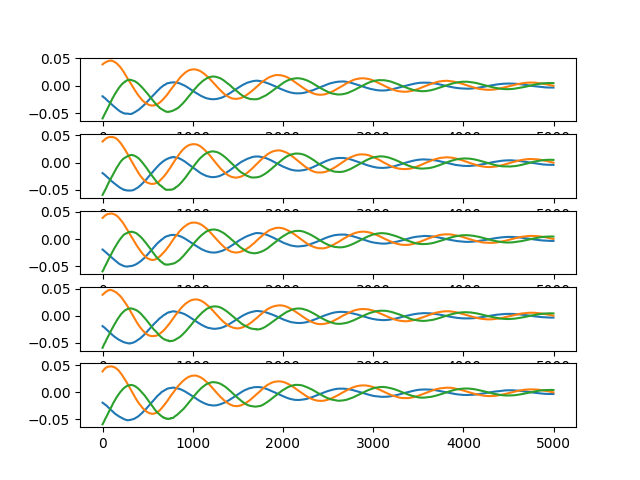

In [831]:
#np.save('xtrain_pupil', xtest[:,:3])
#temp,_,_ = encoder.predict(xtest)
#np.save('xtrain_pupil', temp)
temp = np.load('ztraj_200.npy')

fig, axes = plt.subplots(5,1,sharex='row')
for i, ax in enumerate(axes):
    #a,_ = scale_x.inverse_transform(temp[i,:,:])
    #ax.plot(a)
    ax.plot(temp[i,:,:])
    
plt.show()

<IPython.core.display.Javascript object>


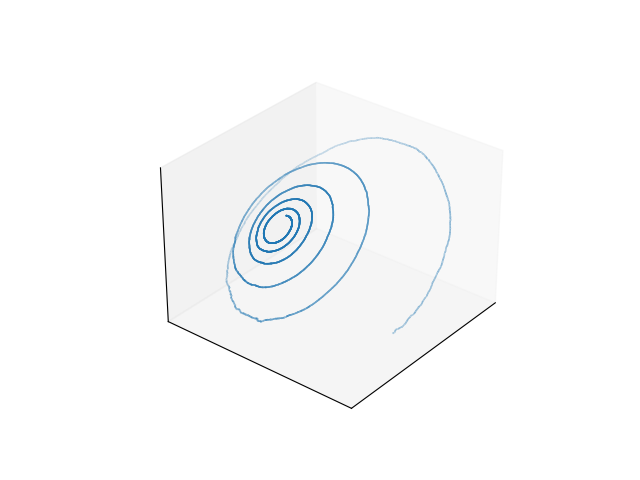

In [832]:
temp1 = temp[-1,:,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = temp1.shape[0]
#temp1 = signal.sosfiltfilt(sos, temp1, axis = 0)
ax.scatter(temp1[:lim,0],temp1[:lim,1],temp1[:lim,2],s=.1,marker ='.')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#plt.axis('off')

ax.view_init(31,39) #0,1,3 view

plt.show()

<IPython.core.display.Javascript object>


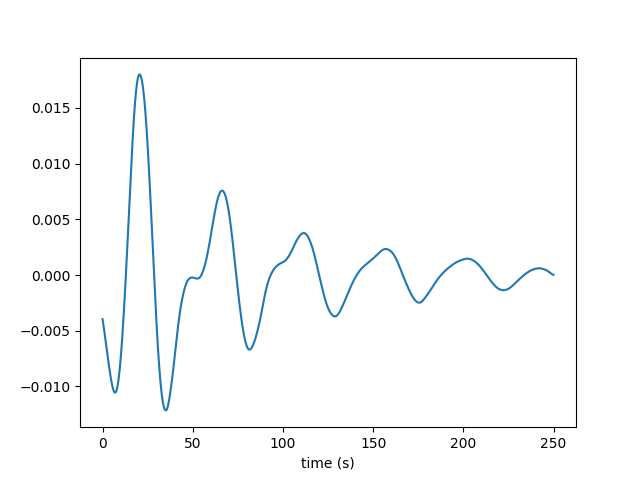

In [833]:
x_sim = model.predict(temp[-1,:])
pupil_sim = x_sim@(Hpu[0,:r_d].T)
sos = signal.butter(2, [.02,.2],btype = 'bandpass', output = 'sos', fs = Fs)
pupil_sim = signal.sosfiltfilt(sos, pupil_sim, axis = 0)

fig,ax = plt.subplots()
#plt.plot(t,.0001*pupil[lag+spacing*(stackmax-1):nsamples+spacing*(stackmax-1)])
plt.plot(.05*np.arange(len(pupil_sim)),10*pupil_sim)
plt.xlabel("time (s)")
plt.show()

# MOVIE

In [14]:
#data1 = temp
data1 = ytest
data2 = ytest_hat

# project back
outmat1 = np.zeros((data1.shape[0],16384), dtype=np.single)
#outmat1[:,mask_long] = StandardScaler(with_std=False).fit_transform(outmat1[:,mask_long])
outmat1[:,mask_long] = StandardScaler(with_std=False).fit_transform(data1)
outmat1 = np.ma.masked_where(outmat1==0, outmat1)
outmat1 = outmat1.reshape(data1.shape[0],128,128,order='F')

outmat2 = np.zeros((data2.shape[0],16384), dtype=np.single)
outmat2[:,mask_long] = StandardScaler(with_std=False).fit_transform(data2)
outmat2 = np.ma.masked_where(outmat2==0, outmat2)
outmat2 = outmat2.reshape(data2.shape[0],128,128,order='F')

In [ ]:
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter

temp = mask.astype(int)
temp = signal.medfilt2d(temp,3)
#temp = zoom(temp,3)
#temp = gaussian_filter(temp,sigma=5)
temp = binary_dilation(temp,iterations=5) - temp
#temp = gaussian_filter(temp,sigma=1) - temp

#temp = np.ma.masked_where(temp<.01, temp)


plt.figure()
plt.imshow(temp)
plt.show()

<IPython.core.display.Javascript object>


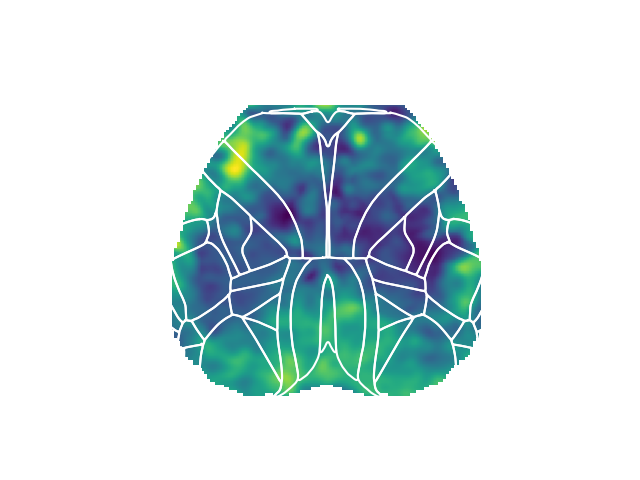

In [200]:
from scipy.ndimage import zoom
plt.figure()
plt.imshow(outmat1[80,:,:], cmap='viridis')
plot_allen_ccf()
#plt.imshow(temp)
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


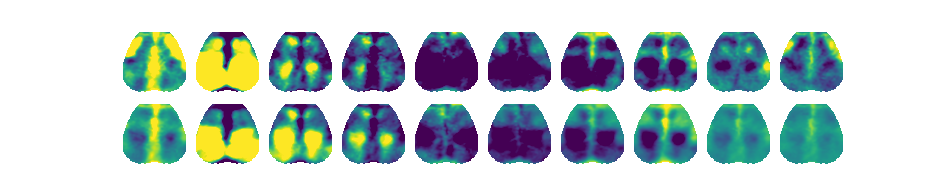

In [15]:
nframes = 10
step = 80 #60
offset = 2179 #100

fig, axes = plt.subplots(2,nframes,sharex='col',figsize=(9.42,1.88))

c1 = .004
c2 = c1


cmap = cm.get_cmap('viridis').copy()
#cmap.set_bad(color='black')

axes = axes.flatten()
for i, ax in enumerate(axes):
    
    if i<nframes:
        ax.imshow(outmat1[i*step + offset,:,:], vmin=-c1, vmax=c1, cmap = cmap)
        
    else:
        ax.imshow(outmat2[(i-nframes)*step + offset,:,:], vmin=-c2, vmax=c2, cmap = cmap)    

    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

#plt.savefig('figure.png', transparent=True)

<IPython.core.display.Javascript object>


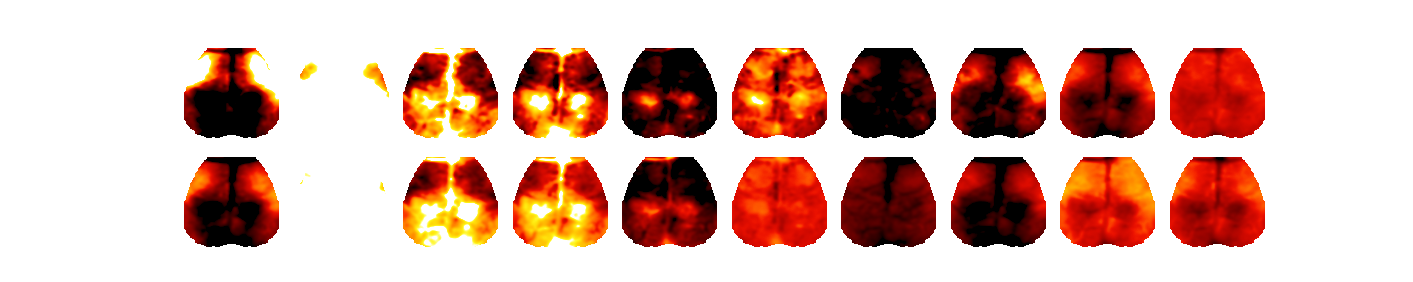

In [56]:
nframes = 10
step = 80
offset = 2179

fig, axes = plt.subplots(2,nframes,sharex='col',figsize=(9.42,1.88))

c1 = .000003
c2 = c1

#cmap = cm.get_cmap('cividis').copy()
cmap = cc.cm.CET_L3
#cmap.set_bad(color='black')

axes = axes.flatten()
for i, ax in enumerate(axes):
    
    if i<8:
        ax.imshow(outmat1[i*step + offset,:,:], vmin=-c1, vmax=c1, cmap = cmap)
        
    else:
        ax.imshow(outmat2[(i-nframes)*step + offset,:,:], vmin=-c2, vmax=c2, cmap = cmap)    

    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


<IPython.core.display.Javascript object>


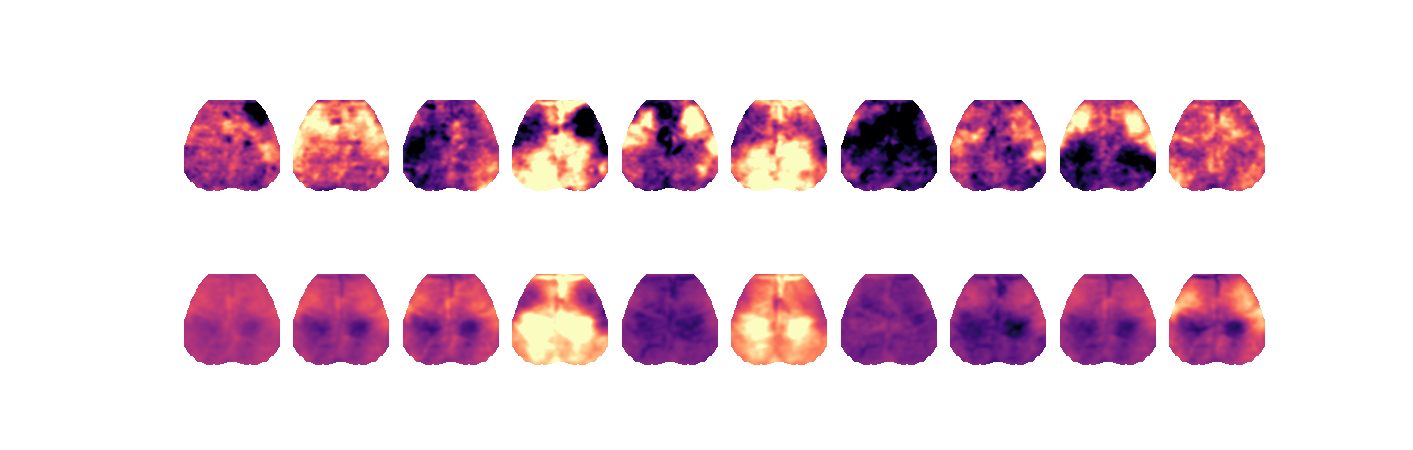

In [133]:
nframes = 10
step = 80
offset = 2179

fig, axes = plt.subplots(2,nframes,sharex='col',figsize=(9.42,3))

#c1 = .005
#c2 = .003

c1 = .007
c2 = c1

axes = axes.flatten()
for i, ax in enumerate(axes):
    
    if i<nframes:
        ax.imshow(outmat1[i*step + offset,:,:], vmin=-c1, vmax=c1, cmap = 'magma')
        
    else:
        ax.imshow(outmat2[(i-nframes)*step + offset,:,:], vmin=-c2, vmax=c2, cmap = 'magma')    

    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


<IPython.core.display.Javascript object>


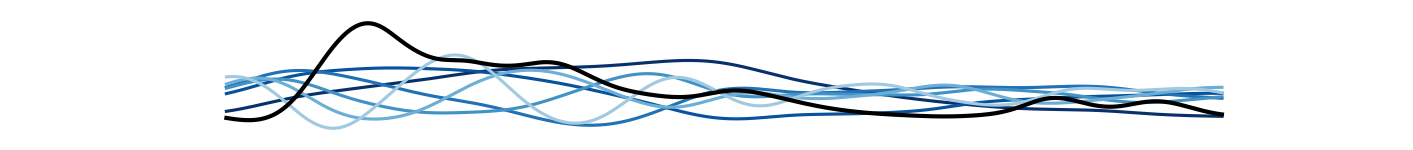

In [188]:
fig, axes = plt.subplots(figsize=(9.42,1))
#temp,_,_ = encoder.predict(xtest[offset:nframes*step+offset,:])
temp = xtest[offset:nframes*step+offset,:]
temp1 = .0005*pupil[(stackmax-1)*spacing + nsamples2:]
temp1 = temp1[offset:nframes*step+offset]

n = 6
colors = plt.cm.Blues_r(np.linspace(0,1,n+2))
for i in range(n):
    plt.plot(temp[:,i], lw=1.5, color=colors[i]) #'b', alpha=1-i/n)
    
plt.plot(temp1,'k',lw=2)
plt.axis('off')
plt.show()

In [18]:
start = 3000
stop = start+3000

tic()
u,s,vh = np.linalg.svd(brain[start:stop,:], full_matrices=False)
toc()

Elapsed time is 127.12256050109863 seconds.


<IPython.core.display.Javascript object>


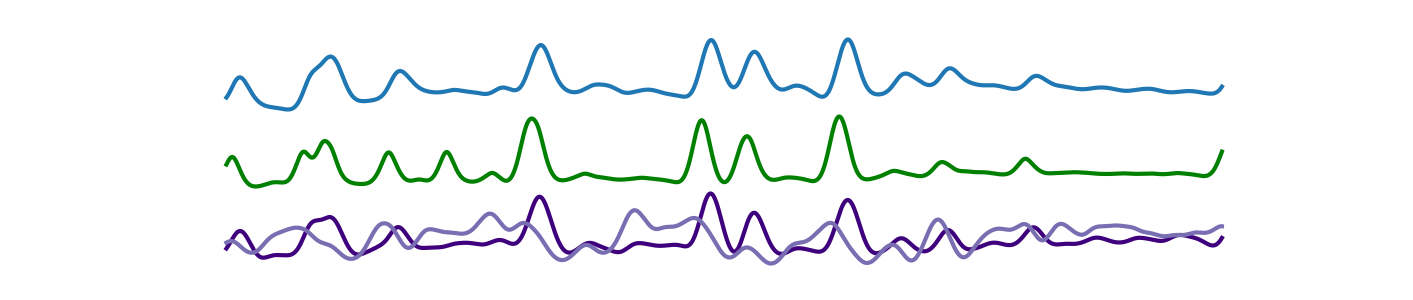

In [48]:
fig, axes = plt.subplots(3, 1, sharex='col', figsize=(9.42,2))

axes[0].plot(pupil[start:stop],lw=2)
axes[1].plot(face[start:stop],'g',lw=2)

n = 2
colors = plt.cm.Purples_r(np.linspace(0,1,n+2))
for i in range(n):
    axes[2].plot(u[:,i], lw=2, color=colors[i]) #*s[i]

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

<IPython.core.display.Javascript object>


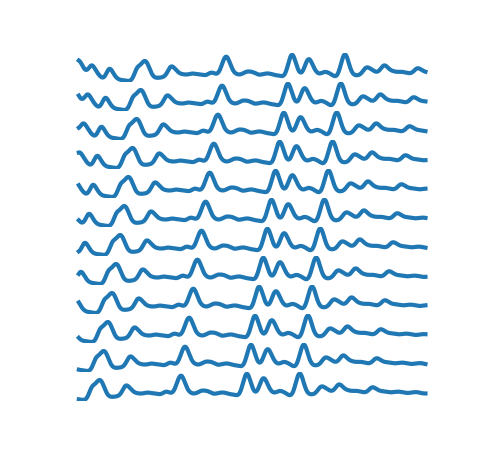

In [17]:
fig, axes = plt.subplots(12,1,sharex='col',figsize=(2.46,2.26),dpi=200)

axes = axes.flatten()
for i, ax in enumerate(axes):
    
    ax.plot(Hp[i*8,2800:5500])

    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

<IPython.core.display.Javascript object>


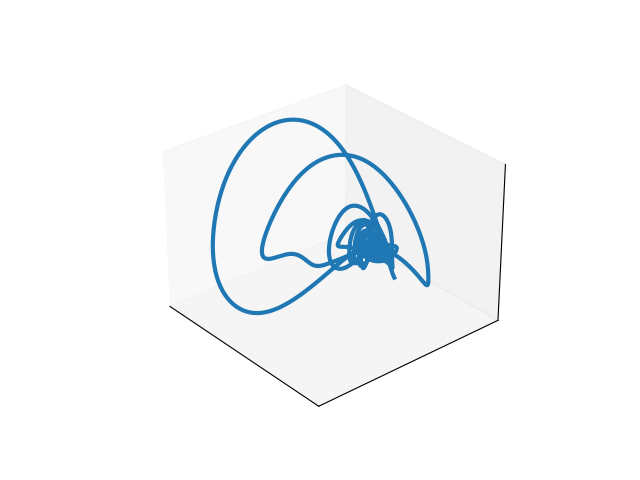

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = 7000
temp = Hpvh.T
#ax.scatter(temp[:lim,0],temp[:lim,1],temp[:lim,2],s=.5,marker ='.')
ax.plot3D(temp[:lim,0],temp[:lim,1],temp[:lim,2],lw=3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#plt.axis('off')

ax.view_init(31,39) #0,1,3 view

plt.show()

In [29]:
#plt.savefig('fad_recon.png', transparent=True, dpi=1200)
#plt.savefig('pupil_predictors.png', transparent=True, dpi=1200)
#plt.savefig('observables.png', transparent=True, dpi=1200)
#plt.savefig('pupil_hankel.png', transparent=True, dpi=1200)
plt.savefig('pupil_traj.png', transparent=True, dpi=1200)

<IPython.core.display.Javascript object>


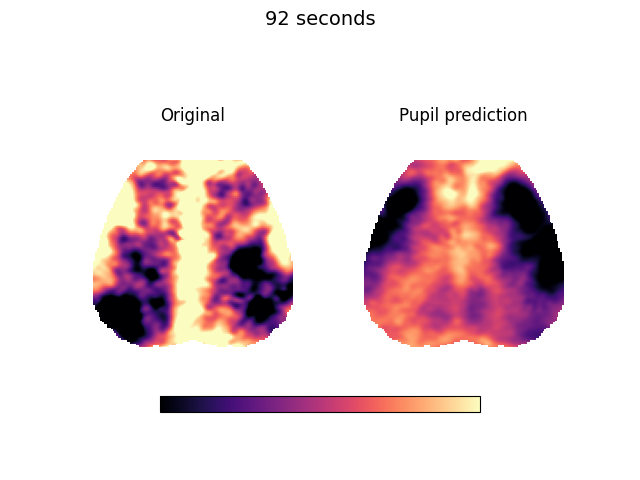

In [94]:
# MOVIE
## animate
c1 = .0015 #.002
c2 = c1
#plt.style.use("dark_background")
# %matplotlib qt
fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.imshow(outmat1[0,:,:], animated=True, vmin=-c1, vmax=c1, cmap = 'magma')
im2 = ax2.imshow(outmat2[0,:,:], animated=True, vmin=-c2, vmax=c2, cmap = 'magma')

ax1.axis('off')
ax2.axis('off')

cbar_ax = fig.add_axes([.25,.1,.5,.5])
cbar_ax.axis('off')
cbar = fig.colorbar(im1,ax=cbar_ax,orientation = "horizontal")
cbar.set_ticks([])

i = 0
def update(*args):
    global i
    if (i<outmat1.shape[0]):
        i += 1
    else:
        i=0
    im1.set_array(outmat1[i,:,:])
    im2.set_array(outmat2[i,:,:])
    ax1.title.set_text('Original')
    ax2.title.set_text('Pupil prediction')
    fig.suptitle(str(np.ceil(i*.05).astype(int)) + ' seconds', fontsize=14)

    return im1, im2,

ani = FuncAnimation(fig, update, blit=True, interval = 5, frames=3000) #5,3000

plt.show()

<IPython.core.display.Javascript object>


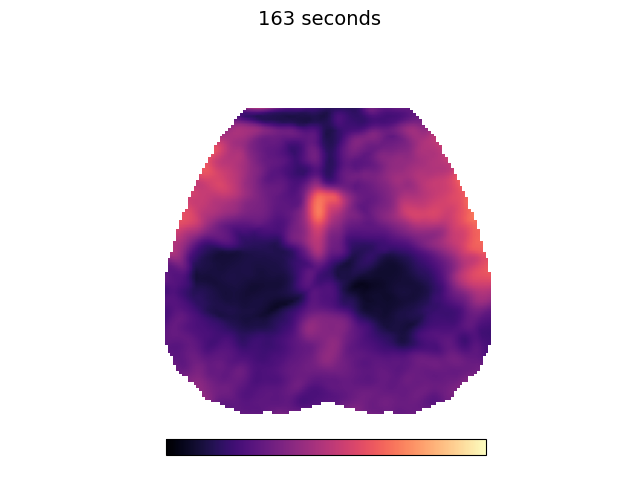

In [239]:
# MOVIE
## animate
c1 = .2
c2 = c1
#plt.style.use("dark_background")
# %matplotlib qt
fig, ax1 = plt.subplots()
im1 = ax1.imshow(outmat1[0,:,:], animated=True, vmin=-c1, vmax=c1, cmap = 'magma')

ax1.axis('off')

cbar_ax = fig.add_axes([.26,.01,.5,.5])
cbar_ax.axis('off')
cbar = fig.colorbar(im1,ax=cbar_ax,orientation = "horizontal")
cbar.set_ticks([])

i = 0
def update(*args):
    global i
    if (i<outmat1.shape[0]):
        i += 1
    else:
        i=0
    im1.set_array(outmat1[i,:,:])
    fig.suptitle(str(np.ceil(i*.05).astype(int)) + ' seconds', fontsize=14)

    return im1

ani = FuncAnimation(fig, update, blit=True, interval = 5, frames=1500) #5,3000

plt.show()

In [79]:
tic()
f = 'dmd_pupil_2.mp4'
writervideo = FFMpegWriter(fps=60)
ani.save(f, writer=writervideo)
toc()

Elapsed time is 47.437050104141235 seconds.


In [332]:
fig = plt.gcf()
fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)

9.42 1.88


<IPython.core.display.Javascript object>


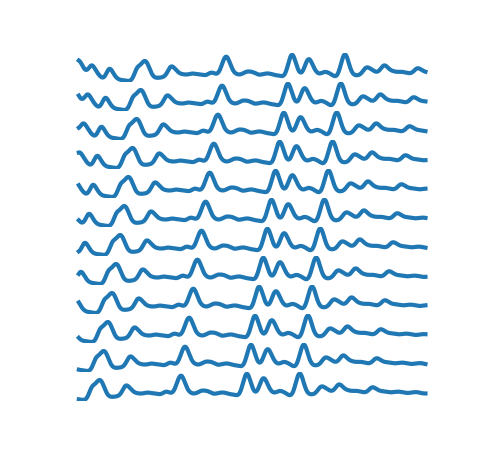

In [350]:
fig, axes = plt.subplots(12,1,sharex='col',figsize=(2.46,2.26),dpi=200)

axes = axes.flatten()
for i, ax in enumerate(axes):
    
    ax.plot(Hp[i*8,2800:5500])

    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()


In [349]:
fig = plt.gcf()
fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)

2.46 2.26


<IPython.core.display.Javascript object>


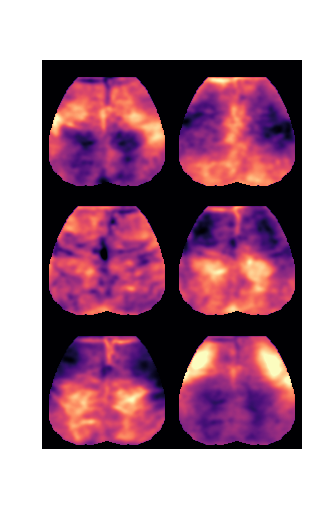

In [455]:
fig, axes = plt.subplots(3,2)

c1 = 1
axes = axes.flatten()

for i, ax in enumerate(axes):
        
    temp = np.mean(yproj[kmeans.labels_==i,:]@spatial_modes[:n,:],axis=0)
    temp = temp.reshape(-1,1)
    temp,_ = scaler(temp)
    outmat1 = np.zeros([16384,1], dtype=np.single)
    outmat1[mask_long] = temp
    outmat1[~mask_long] = -c1
    outmat1 = outmat1.reshape(128,128,order='F')
    
    ax.imshow(outmat1, vmin=-c1, vmax=c1, cmap = 'magma')


    ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [451]:
from deeptime.kernels import GaussianKernel
from deeptime.decomposition import KernelEDMD

X = ytest[:-1,:]#@spatial_modes[:n,:]
Y = ytest[1:,:]#@spatial_modes[:n,:]

sigma = 20 # kernel bandwidth
kernel = GaussianKernel(sigma)

n_eigs = 6 # number of eigenfunctions to be computed
kedmd_estimator = KernelEDMD(kernel, n_eigs=n_eigs, epsilon=1e-3)
kedmd_model = kedmd_estimator.fit((X, Y)).fetch_model()

phi = kedmd_model.transform(X)
#phi[:,1] = np.abs(phi[:,1])
#phi[:,2] = np.angle(phi[:,2])

# normalize
for i in range(n_eigs):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))


<IPython.core.display.Javascript object>


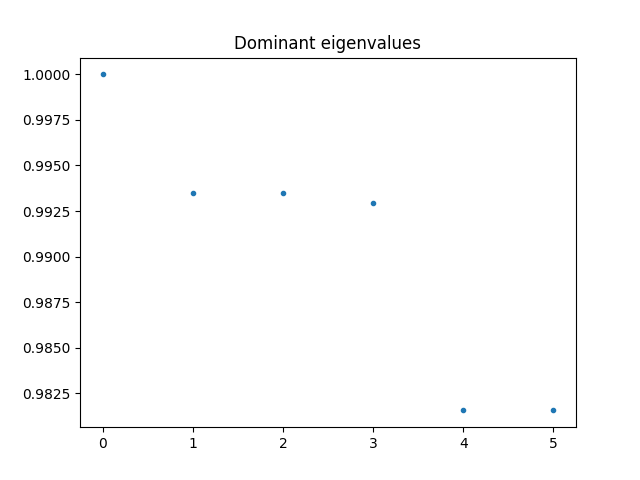

Text(0.5, 1.0, 'Dominant eigenvalues')

In [434]:
d = np.real(kedmd_model.eigenvalues)
plt.plot(d, '.')
plt.title('Dominant eigenvalues')

In [446]:
kedmd_model.eigenvectors.shape

(3722, 6)

<IPython.core.display.Javascript object>


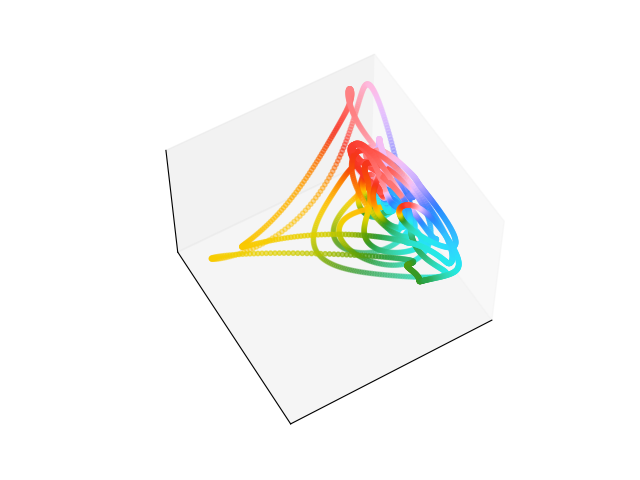

In [445]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = X.shape[0]
colors = phi[:,2]
ax.scatter(X[:lim,0],X[:lim,1],X[:lim,2],s=40,marker ='.',c=colors[:lim],cmap=cc.cm.CET_C6)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.view_init(31,39) #0,1,3 view

plt.show()

<IPython.core.display.Javascript object>


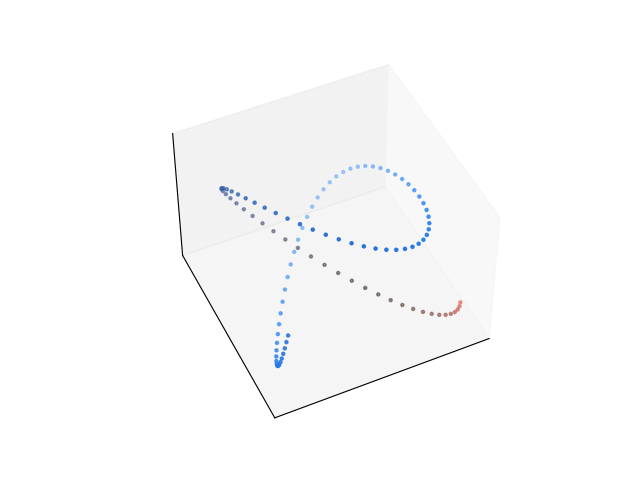

In [537]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lim = 100
#colors = Hp[0,:lim].T
colors = yproj[:lim,0]
ax.scatter(Hpu[:lim,3],Hpu[:lim,4],Hpu[:lim,2],s=20,marker ='.',c=colors[:lim],cmap=cc.cm.CET_D4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.view_init(31,39) #0,1,3 view

plt.show()

In [48]:
latent = xtrain
lim = 8000
#colors = ytrain[:,5]
colors = np.arctan2(xtrain[:,1],xtrain[:,2])
#colors = np.sqrt(xtrain[:,1]**2+xtrain[:,2]**2)
#colors = ytrain[:,5]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(latent[:lim,0],latent[:lim,1],latent[:lim,2],s=1,c=colors[:lim],cmap='hsv')

#for j in range(4):
c=3
for i in range(num_bins): # col by col
    #ax.scatter(.5*yy[:,i],.25*np.cos(tr)[:,i],.25*np.sin(tr)[:,i],s=1,c=colors[:100],cmap=C6)
   # ax.scatter(0*x_vals[:,i],x_vals[:,i],y_vals[:,i],s=1,c=Z[:,i,0],cmap='turbo',vmin=-c,vmax=c)
   # ax.scatter(.2+0*yy[:,i],x_vals[:,i],y_vals[:,i],s=1,c=Z[:,i,5],cmap='turbo',vmin=-c,vmax=c)
   # ax.scatter(-.2+0*yy[:,i],x_vals[:,i],y_vals[:,i],s=1,c=Z[:,i,3],cmap='turbo',vmin=-c,vmax=c)
    #ax.scatter((-.4+j*.2)+0*yy[:,i],.2*x_vals[:,i],.2*y_vals[:,i],s=1,c=Z[:,i,4],cmap='viridis',vmin=-15,vmax=15)

#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])

plt.show()

IndentationError: expected an indented block (1812808618.py, line 24)

<IPython.core.display.Javascript object>


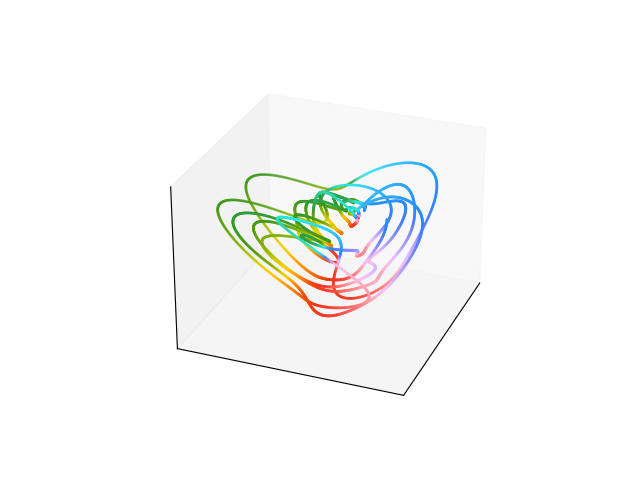

In [54]:
latent = xtrain
lim = 8000
#colors = ytrain[:,5]
colors = np.arctan2(xtrain[:,1],xtrain[:,2])
#colors = np.sqrt(xtrain[:,1]**2+xtrain[:,2]**2)
#colors = ytrain[:,5]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(latent[:lim,0],latent[:lim,1],latent[:lim,2],s=1,c=colors[:lim],cmap=cc.cm.CET_C6)

#for j in range(4):
c=3
#for i in range(num_bins): # col by col
    #ax.scatter(.5*yy[:,i],.25*np.cos(tr)[:,i],.25*np.sin(tr)[:,i],s=1,c=colors[:100],cmap=C6)
#    ax.scatter(0*yy[:,i],x_vals[:,i],y_vals[:,i],s=1,c=Z[:,i,0],cmap='turbo',vmin=-c,vmax=c)
   # ax.scatter(.2+0*yy[:,i],x_vals[:,i],y_vals[:,i],s=1,c=Z[:,i,5],cmap='turbo',vmin=-c,vmax=c)
   # ax.scatter(-.2+0*yy[:,i],x_vals[:,i],y_vals[:,i],s=1,c=Z[:,i,3],cmap='turbo',vmin=-c,vmax=c)
    #ax.scatter((-.4+j*.2)+0*yy[:,i],.2*x_vals[:,i],.2*y_vals[:,i],s=1,c=Z[:,i,4],cmap='viridis',vmin=-15,vmax=15)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

<IPython.core.display.Javascript object>


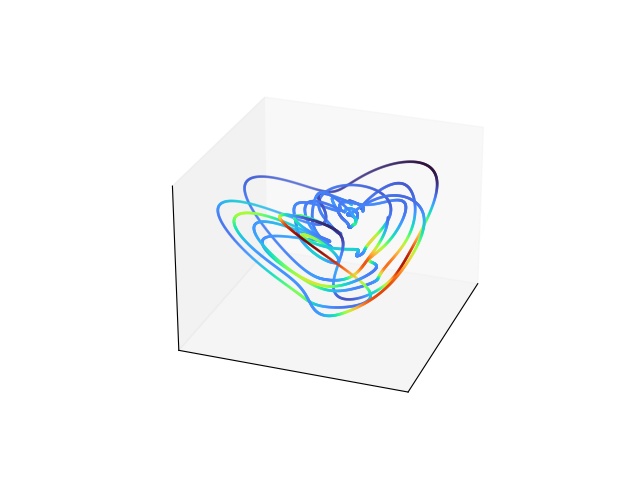

NameError: name 'colorbar' is not defined

In [107]:
latent = xtrain
lim = 8000
#colors = xtrain[:,0]
#colors = np.arctan2(xtrain[:,1],xtrain[:,2])
#colors = np.sqrt(xtrain[:,1]**2+xtrain[:,2]**2)
colors = ytrain[:,0]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(latent[:lim,0],latent[:lim,1],latent[:lim,2],s=1,c=colors[:lim],cmap='turbo') #cc.cm.CET_C6 #turbo
ax.scatter(latent[:lim,0],latent[:lim,1],latent[:lim,2],s=1,c=colors[:lim],cmap='turbo') #cc.cm.CET_C6 #turbo


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


ax.azim = azim
ax.dist = dist
ax.elev = elev
plt.show()

In [76]:
azim = ax.azim
dist = ax.dist
elev = ax.elev